In [1]:
import torch
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import re, magic

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
#import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage import zoom
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

#vit
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [2]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))


Images:  290400
Image_labels: 290400


In [3]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df

low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

Index(['BMW/3시리즈/2019', 'BMW/3시리즈/2020', 'BMW/5시리즈/2019', 'BMW/5시리즈/2020',
       'BMW/5시리즈/2021', 'BMW/7시리즈/2017', 'BMW/7시리즈/2018', 'BMW/7시리즈/2019',
       'BMW/7시리즈/2020', 'BMW/X3/2017',
       ...
       '현대/코나/2021', '현대/투싼/2021', '현대/포터2/2018', '현대/포터2/2019', '현대/포터2/2020',
       '현대/포터2/2021', '혼다/CR-V/2017', '혼다/CR-V/2021', '혼다/어코드/2017',
       '혼다/어코드/2021'],
      dtype='object', length=236)

In [4]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020


In [5]:
labels = train.label.value_counts().index
labels

Index(['벤츠/E-Class/2017', '현대/코나/2018', '기아/모닝/2017', '기아/K3/2019',
       '기아/스포티지/2018', '제네시스/G80/2018', '기아/쏘렌토/2017', '현대/아반떼/2018',
       '기아/모닝/2018', '기아/K7/2017',
       ...
       '기아/모하비/2017', '제네시스/G90/2019', '쉐보레/올란도/2018', '르노삼성/SM5/2017',
       '현대/코나/2020', '기아/니로/2018', '쉐보레/스파크/2020', '현대/스타렉스/2020',
       '현대/팰리세이드/2020', '기아/니로/2019'],
      dtype='object', length=134)

In [7]:
car_com = []
for i,label in enumerate(labels):
    company = label.split('/')[0]
    if company not in car_com:
        car_com.append(company)
car_com = dict.fromkeys(car_com)
    
for i,label in enumerate(labels):
    company = label.split('/',1)[0]
    car_com[company] = []

for i,label in enumerate(labels):
    company = label.split('/',1)[0]
    value = label.split('/',1)[1]
    car_com[company].append(value)
    car_com[company].sort()
    
car_com

{'벤츠': ['C-Class/2017',
  'E-Class/2017',
  'E-Class/2018',
  'E-Class/2019',
  'E-Class/2020',
  'S-Class/2017',
  'S-Class/2018'],
 '현대': ['그랜저/2017',
  '그랜저/2018',
  '그랜저/2019',
  '그랜저/2020',
  '그랜저/2021',
  '베뉴/2020',
  '스타렉스/2017',
  '스타렉스/2018',
  '스타렉스/2019',
  '스타렉스/2020',
  '싼타페/2017',
  '싼타페/2018',
  '싼타페/2019',
  '싼타페/2020',
  '쏘나타/2017',
  '쏘나타/2018',
  '쏘나타/2019',
  '쏘나타/2020',
  '쏘나타/2021',
  '아반떼/2017',
  '아반떼/2018',
  '아반떼/2019',
  '아반떼/2020',
  '아반떼/2021',
  '코나/2018',
  '코나/2019',
  '코나/2020',
  '투싼/2017',
  '투싼/2018',
  '투싼/2019',
  '투싼/2020',
  '팰리세이드/2019',
  '팰리세이드/2020',
  '팰리세이드/2021',
  '포터2/2017'],
 '기아': ['K3/2017',
  'K3/2018',
  'K3/2019',
  'K3/2020',
  'K3/2021',
  'K5/2017',
  'K5/2018',
  'K5/2019',
  'K5/2020',
  'K7/2017',
  'K7/2018',
  'K7/2019',
  'K7/2020',
  'K9/2019',
  'K9/2020',
  'K9/2021',
  '니로/2017',
  '니로/2018',
  '니로/2019',
  '니로/2020',
  '레이/2017',
  '레이/2018',
  '레이/2019',
  '레이/2020',
  '모닝/2017',
  '모닝/2018',
  '모닝/2019',
  '모닝/2020'

In [6]:
label_value = train['label'].values
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

LabelEncoder()

In [53]:
le.classes_



array(['BMW/3시리즈/2017', 'BMW/3시리즈/2018', 'BMW/5시리즈/2017', 'BMW/5시리즈/2018',
       '기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '랜드로버/레인지로버/2017', '르노삼성/QM3/2017',
       '르노삼성/QM6/2017', '르노삼성/QM6/2018', '르노삼성/QM6/2019', '르노삼성/QM6/2020',

In [8]:
path = '../Data/car_dataset_sample/'
#path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  1897
Image_labels: 1897


In [9]:

test_df = pd.DataFrame(img_names, columns=['image_id'])
test_df['dir'] = test_df['image_id'].apply(lambda x: os.path.dirname(x))
test_df['image_id'] = test_df['image_id'].apply(lambda x: os.path.basename(x))
test_df['label'] = img_labels

label_value = []
for i, di in enumerate(test_df['dir']):
    dir_l = di[30:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

# label_value
test_df['label'] = label_value
test = test_df
test

,image_id,dir,label
0,C_211111_SS_097_21_RE_B_T_03_013.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,쌍용/티볼리/2021
1,C_211111_SS_097_21_RE_B_P_01_031.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,쌍용/티볼리/2021
2,C_211111_SS_097_21_RE_B_P_01_058.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,쌍용/티볼리/2021
3,C_210914_SS_097_20_WH_A_P_01_062.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2020_...,쌍용/티볼리/2020
4,C_210914_SS_097_20_WH_A_T_02_003.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2020_...,쌍용/티볼리/2020
...,...,...,...
1892,C_211001_KG_044_17_BL_A_P_01_045.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/201...,한국지엠/다마스/2017
1893,C_211001_KG_044_17_BL_A_P_01_050.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/201...,한국지엠/다마스/2017
1894,C_210930_KG_044_21_WH_A_P_01_036.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/202...,한국지엠/다마스/2021
1895,C_210930_KG_044_21_WH_A_P_01_033.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/202...,한국지엠/다마스/2021


In [15]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = test[test['label'] == low_data[i]].index
    test.drop(idx, inplace=True)
test.reset_index(inplace=True, drop=True)
test
# idx

KeyError: 'label'

In [9]:
# 인코딩한 데이터로 변환
le_encoded = le.transform(test['label'])

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
test['label'] = new_cat
test

NameError: name 'test' is not defined

In [7]:
#for whole inference (without label)
test_imgs = os.listdir('test_data/')
test_imgs

['k3.jpg',
 'soul.jpg',
 'mohave.jpg',
 'stonic.jpg',
 'niro.jpg',
 'sorento.jpg',
 'stinger.jpg',
 'seltos.jpg',
 'ray.jpg',
 'morning.jpg',
 'bongo3.jpeg',
 'k7.jpg',
 'spotage.jpg',
 'k5.jpg',
 'k9.jpg']

In [8]:
#for whole inference (without label)
df_test = pd.DataFrame(columns = ['image_id'])

In [9]:
df_test['image_id'] = test_imgs

In [10]:
df_test.head()

,image_id
0,k3.jpg
1,soul.jpg
2,mohave.jpg
3,stonic.jpg
4,niro.jpg


In [14]:
test = df_test.copy()

In [15]:
test.shape

(15, 1)

In [25]:
tst_preds.sort(axis=1)

In [47]:
#pred_test = np.argmax(tst_preds, axis=1)
pred_test = tst_preds[0]
pred_test.argsort()[-3:][::-1]

array([ 8,  6, 16])

In [52]:
pred_test[16]

0.00015336274

In [48]:
np.max(pred_test)

0.9963206

In [49]:
np.argmax(pred_test)

8

In [21]:
tst_preds

array([[2.34609227e-16, 1.00297154e-14, 1.27243669e-14, ...,
        1.53362736e-04, 3.40515980e-03, 9.96320605e-01],
       [2.05972067e-12, 4.37432339e-12, 5.24573484e-12, ...,
        1.58235934e-02, 3.29564624e-02, 9.39375818e-01],
       [1.01917430e-13, 1.09635689e-13, 1.23436580e-13, ...,
        1.49398167e-02, 1.81223914e-01, 8.00965905e-01],
       ...,
       [4.31766151e-11, 9.58313359e-11, 1.66361730e-10, ...,
        8.73116776e-02, 1.82412758e-01, 5.65053642e-01],
       [2.75954661e-13, 1.87626780e-12, 3.19470297e-12, ...,
        3.24063213e-03, 5.22440998e-03, 9.88071799e-01],
       [5.52952519e-12, 1.76893597e-10, 2.73947892e-10, ...,
        1.22849315e-01, 2.31509715e-01, 3.21604878e-01]], dtype=float32)

In [16]:
test

,image_id
0,k3.jpg
1,soul.jpg
2,mohave.jpg
3,stonic.jpg
4,niro.jpg
5,sorento.jpg
6,stinger.jpg
7,seltos.jpg
8,ray.jpg
9,morning.jpg


In [27]:
dist.destroy_process_group()

In [56]:
le.inverse_transform([4])

array(['기아/K3/2017'], dtype=object)

In [ ]:
%run classification_inference_efficientnet.ipynb

In [12]:
%run prediction.py niro.jpg

['niro.jpg']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]

top_3 : [ 44  23 112]
['기아/스포티지/2019' '기아/니로/2020' '현대/싼타페/2020']


In [12]:
dist.destroy_process_group()

In [30]:
test['trans'] = le.inverse_transform(test['pred'])

# pred = []
# for i, pr in enumerate(test['pred']):
#     #print(pr[i])
#     tmp = le.inverse_transform(int(pr))
#     print(tmp)
#     pred.append(tmp)
# #test['pred'] = pred
test

,image_id,pred,confidence score,trans
0,k3.jpg,8,0.996321,기아/K3/2021
1,soul.jpg,131,0.939376,현대/팰리세이드/2020
2,mohave.jpg,34,0.800966,기아/모하비/2018
3,stonic.jpg,37,0.855775,기아/스토닉/2018
4,niro.jpg,23,0.883775,기아/니로/2020
5,sorento.jpg,49,0.999841,기아/쏘렌토/2021
6,stinger.jpg,39,0.999900,기아/스팅어/2018
7,seltos.jpg,36,0.999951,기아/셀토스/2021
8,ray.jpg,24,0.998347,기아/레이/2017
9,morning.jpg,32,0.970845,기아/모닝/2021


In [23]:
test['label'] = le.inverse_transform(test['label'])

In [26]:
test_acc = np.sum(test.label == test.trans) / len(test)
#test_matrix = confusion_matrix(test['label'], test['pred'])
print(test_acc)
#print(test_matrix)

0.635386119257087


In [32]:
del tst_preds
torch.cuda.empty_cache()

In [24]:
test

,image_id,dir,label,pred,confidence score,trans
0,C_210819_SS_097_18_WH_A_T_03_023.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,8.816254e-06,0.251387,포드/익스플로러/2017
1,C_210819_SS_097_18_WH_A_T_03_002.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,6.098955e-06,0.270263,기아/쏘렌토/2021
2,C_210819_SS_097_18_WH_A_P_01_001.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,1.286609e-15,1.000000,쌍용/티볼리/2018
3,C_211025_SS_097_18_GR_A_P_01_059.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,1.486396e-11,0.916679,쌍용/티볼리/2018
4,C_211025_SS_097_18_GR_A_P_01_054.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,8.903253e-14,0.856011,쌍용/티볼리/2017
...,...,...,...,...,...,...
1018,C_211124_BE_014_19_BK_C_P_01_061.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,4.255014e-21,1.000000,벤츠/E-Class/2019
1019,C_211124_BE_014_19_BK_C_P_01_023.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,1.170289e-17,0.957611,벤츠/E-Class/2019
1020,C_211112_BE_014_19_WH_C_T_03_012.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,2.167510e-05,0.568624,쉐보레/스파크/2018
1021,C_211112_BE_014_19_WH_C_T_03_010.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,4.478291e-03,0.302938,벤츠/E-Class/2018


In [7]:
#model performance check by epoch
#test_dir = '/Data/data/data_gsun/data/cecum/cecum_test_frames'

list_models = os.listdir('efficientnet_lite0/')
# list_models = os.listdir('8th_epoch_11/')
list_models = sorted(list_models)
box_acc = []
box_conf = []
for i,model in enumerate(list_models):
    print(model, i)
    perf = []
    model_dir = 'efficientnet_lite0/' + model
#     model_dir = '8th_epoch_11/' + model
    %run classification_inference_efficientnet.ipynb
    
    test['pred'] = np.argmax(tst_preds, axis=1)
    test_acc = np.sum(test.label == test.pred) / len(test)
    test_matrix = confusion_matrix(test['label'], test['pred'])
    box_acc.append(test_acc)
    box_conf.append(test_matrix)
    
    print(test_acc)
    #print(test_matrix)
    print('---------------------------------------')
    dist.destroy_process_group()


20%_drop_efficientnet_lite0_0 0


100%|█████████████████████████████████████████| 119/119 [00:16<00:00,  7.15it/s]


0.4164470216130733
---------------------------------------
20%_drop_efficientnet_lite0_1 1


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  9.00it/s]


0.5482340537691092
---------------------------------------
20%_drop_efficientnet_lite0_10 2


100%|█████████████████████████████████████████| 119/119 [00:14<00:00,  8.45it/s]


0.7158671586715867
---------------------------------------
20%_drop_efficientnet_lite0_11 3


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.77it/s]


0.7174486030574592
---------------------------------------
20%_drop_efficientnet_lite0_12 4


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.83it/s]


0.720611491829204
---------------------------------------
20%_drop_efficientnet_lite0_13 5


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.93it/s]


0.7221929362150764
---------------------------------------
20%_drop_efficientnet_lite0_14 6


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.97it/s]


0.7395888244596732
---------------------------------------
20%_drop_efficientnet_lite0_15 7


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.82it/s]


0.7227200843437006
---------------------------------------
20%_drop_efficientnet_lite0_16 8


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.93it/s]


0.7274644175013179
---------------------------------------
20%_drop_efficientnet_lite0_17 9


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.87it/s]


0.7253558249868213
---------------------------------------
20%_drop_efficientnet_lite0_18 10


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.92it/s]


0.727991565629942
---------------------------------------
20%_drop_efficientnet_lite0_19 11


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.77it/s]


0.7216657880864523
---------------------------------------
20%_drop_efficientnet_lite0_2 12


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.80it/s]


0.6204533473906167
---------------------------------------
20%_drop_efficientnet_lite0_20 13


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.72it/s]


0.7311544544016869
---------------------------------------
20%_drop_efficientnet_lite0_21 14


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.96it/s]


0.739061676331049
---------------------------------------
20%_drop_efficientnet_lite0_22 15


100%|█████████████████████████████████████████| 119/119 [00:14<00:00,  8.49it/s]


0.7221929362150764
---------------------------------------
20%_drop_efficientnet_lite0_23 16


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  9.02it/s]


0.727991565629942
---------------------------------------
20%_drop_efficientnet_lite0_24 17


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.81it/s]


0.739061676331049
---------------------------------------
20%_drop_efficientnet_lite0_25 18


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.78it/s]


0.7416974169741697
---------------------------------------
20%_drop_efficientnet_lite0_26 19


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.83it/s]


0.7322087506589352
---------------------------------------
20%_drop_efficientnet_lite0_27 20


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.77it/s]


0.720611491829204
---------------------------------------
20%_drop_efficientnet_lite0_28 21


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.82it/s]


0.7443331576172905
---------------------------------------
20%_drop_efficientnet_lite0_29 22


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.86it/s]


0.7422245651027939
---------------------------------------
20%_drop_efficientnet_lite0_3 23


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.80it/s]


0.6568265682656826
---------------------------------------
20%_drop_efficientnet_lite0_4 24


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.87it/s]


0.6647337901950449
---------------------------------------
20%_drop_efficientnet_lite0_5 25


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.70it/s]


0.6868740115972588
---------------------------------------
20%_drop_efficientnet_lite0_6 26


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.64it/s]


0.6995255666842383
---------------------------------------
20%_drop_efficientnet_lite0_7 27


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  9.08it/s]


0.7026884554559831
---------------------------------------
20%_drop_efficientnet_lite0_8 28


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.98it/s]


0.7100685292567211
---------------------------------------
20%_drop_efficientnet_lite0_9 29


100%|█████████████████████████████████████████| 119/119 [00:13<00:00,  8.89it/s]


0.7032156035846073
---------------------------------------


In [8]:
test

,image_id,dir,label,pred,confidence score
0,C_211111_SS_097_21_RE_B_T_03_013.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,350,350,0.808191
1,C_211111_SS_097_21_RE_B_P_01_031.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,350,349,0.553947
2,C_211111_SS_097_21_RE_B_P_01_058.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,350,349,0.927482
3,C_210914_SS_097_20_WH_A_P_01_062.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2020_...,349,31,0.864332
4,C_210914_SS_097_20_WH_A_T_02_003.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2020_...,349,348,0.638279
...,...,...,...,...,...
1892,C_211001_KG_044_17_BL_A_P_01_045.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/201...,194,194,1.000000
1893,C_211001_KG_044_17_BL_A_P_01_050.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/201...,194,194,0.999248
1894,C_210930_KG_044_21_WH_A_P_01_036.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/202...,198,198,1.000000
1895,C_210930_KG_044_21_WH_A_P_01_033.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/202...,198,198,0.999999


In [128]:
print(max(box_acc), box_acc.index(max(box_acc)))

0.7961290322580645 16


In [126]:
for i,e in enumerate(box_acc):
    print(i, e, '\n', box_conf[i])

0 0.7445161290322581 
 [[1304  556]
 [  38  427]]
1 0.7359139784946237 
 [[1263  597]
 [  17  448]]
2 0.5324731182795699 
 [[ 779 1081]
 [   6  459]]
3 0.6365591397849463 
 [[1020  840]
 [   5  460]]
4 0.6103225806451613 
 [[972 888]
 [ 18 447]]
5 0.6305376344086021 
 [[1010  850]
 [   9  456]]
6 0.6365591397849463 
 [[1025  835]
 [  10  455]]
7 0.7832258064516129 
 [[1393  467]
 [  37  428]]
8 0.7604301075268817 
 [[1397  463]
 [  94  371]]
9 0.8473118279569892 
 [[1527  333]
 [  22  443]]
10 0.704516129032258 
 [[1184  676]
 [  11  454]]
11 0.6116129032258064 
 [[973 887]
 [ 16 449]]
12 0.6640860215053763 
 [[1098  762]
 [  19  446]]
13 0.5604301075268817 
 [[ 845 1015]
 [   7  458]]
14 0.7845161290322581 
 [[1392  468]
 [  33  432]]
15 0.6163440860215054 
 [[980 880]
 [ 12 453]]
16 0.6159139784946237 
 [[970 890]
 [  3 462]]
17 0.6692473118279569 
 [[1101  759]
 [  10  455]]
18 0.501505376344086 
 [[ 703 1157]
 [   2  463]]
19 0.6404301075268817 
 [[1054  806]
 [  30  435]]
20 0.766

In [15]:
#for whole inference (without label)
test_dir = '/home/super/endo_venv/gsun/blur_classification/inferenced_data/'
model_dir = '3rd_epoch_44/20%_drop_efficientnet_lite0_44'

In [114]:
#for inference with labeled data
test_dir = '/Data/data/data_gsun/data/cecum/cecum_test_frames'
model_dir = '7th_epoch_0/20%_drop_efficientnet_lite0_0'

In [115]:
%run classification_inference_efficientnet.ipynb

100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:13<00:00, 17.02it/s]


In [17]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
test['confidence score'] =np.max(tst_preds, axis=1)
# test_acc = np.sum(test.label == test.pred) / len(test)
# test_matrix = confusion_matrix(test['label'], test['pred'])
# print(round(test_acc, 5))
# print(test_matrix)

In [18]:
test.head(10)

,image_id,pred,confidence score
0,/clean/V1492_2021_0042_002196.png,0,0.999430
1,/clean/V1492_2021_0042_000279.png,0,0.990559
2,/clean/V1492_2021_0042_003584.png,0,0.999930
3,/clean/V1492_2021_0042_002230.png,0,0.983210
4,/clean/V1492_2021_0042_000013.png,0,0.993555
5,/clean/V1492_2021_0042_004370.png,0,0.999907
6,/clean/V1492_2021_0042_003993.png,0,0.999983
7,/clean/V1492_2021_0042_000096.png,0,0.999649
8,/clean/V1492_2021_0042_004724.png,0,0.972563
9,/clean/V1492_2021_0042_000993.png,0,0.866875


In [19]:
test.shape

(2055, 3)

In [20]:
test.pred.value_counts()

0    2037
1      18
Name: pred, dtype: int64

<AxesSubplot:>

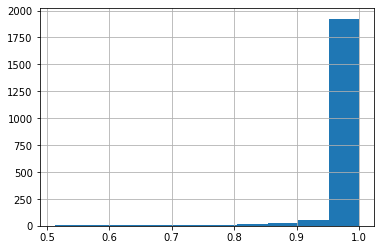

In [21]:
test['confidence score'].hist()

In [22]:
test_true = test.loc[(test.pred == 1) & (test['confidence score'] >= 0.975)].copy()

In [23]:
test_true = test.loc[test.pred == 1].copy()

In [24]:
test_true.shape

(18, 3)

In [25]:
test_true.head(3)

,image_id,pred,confidence score
296,/clean/V1492_2021_0042_001225.png,1,0.848870
303,/clean/V1492_2021_0042_001879.png,1,0.684942
361,/clean/V1492_2021_0042_001227.png,1,0.934809


In [26]:
true_names = test_true.image_id.tolist()

In [27]:
print(len(true_names))

18


In [28]:
from shutil import copyfile
for e in true_names:
    copyfile('/home/super/endo_venv/gsun/blur_classification/inferenced_data' + e, '/Data/data/data_gsun/Cecum/inferenced/cecum/' + e.split('/')[2])

In [29]:
test_false = test.loc[test.pred == 0].copy()

In [30]:
false_names = test_false.image_id.tolist()

In [31]:
from shutil import copyfile
for e in false_names:
    copyfile('/home/super/endo_venv/gsun/blur_classification/inferenced_data' + e, '/Data/data/data_gsun/Cecum/inferenced/non_cecum/' + e.split('/')[2])

In [39]:
test_clean = test.loc[(test.pred == 0) & (test['confidence score'] >= 0.975)].copy()

In [40]:
test_clean.shape

(4037, 3)

In [41]:
test_clean.head(3)

,image_id,pred,confidence score
7,/1732/V1732_00008.png,0,0.985698
16,/1732/V1732_00017.png,0,0.981278
17,/1732/V1732_00018.png,0,0.992170


In [42]:
clean_names = test_clean.image_id.tolist()

In [43]:
names = blur_names + clean_names

In [44]:
print(len(names))

6943


In [45]:
from shutil import copyfile

In [46]:
for i,e in enumerate(names):
    if i < len(blur_names):
        copyfile('/Data/data/blur_detection' + e, '/Data/data/blur_detection/result_1732_blur' + e[5:])
    else:
        copyfile('/Data/data/blur_detection' + e, '/Data/data/blur_detection/result_1732_clean' + e[5:])
# copyfile('/Data/data/blur_detection','C:\\test\\test_copy.txt')

In [86]:
def segger(x):
    y = None
    if type(x) == str:
        xx = x.split('/')[-1]
        if 'AC' in xx:
            y = 'AC'
        elif 'TC' in xx:
            y = 'TC'
        elif 'DC' in xx:
            y = 'DC'
        elif 'SC' in xx:
            y = 'SC'
        elif 'Rec' in xx:
            y = 'Rectum'
        else:
            y = 'Cecum'
            
    return y

In [116]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
#test['confidence score'] =np.max(tst_preds, axis=1)
test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
print(round(test_acc, 5))
print(test_matrix)

0.81505
[[1484  376]
 [  54  411]]


In [117]:
test.head(5)

,image_id,label,pred,confidence score,segment
0,/cecum/V0246_2020_0016_001613.png,1,1,0.960615,Cecum
1,/cecum/V0246_2020_0016_001435.png,1,1,0.998785,Cecum
2,/cecum/V0246_2020_0016_001430.png,1,1,0.997008,Cecum
3,/cecum/V0246_2020_0016_001425.png,1,1,0.999448,Cecum
4,/cecum/V0244_2020_0014_001780.png,1,1,0.961064,Cecum


In [118]:
test['segment'] = test['image_id'].apply(segger)

In [119]:
test.head(10)

,image_id,label,pred,confidence score,segment
0,/cecum/V0246_2020_0016_001613.png,1,1,0.960615,Cecum
1,/cecum/V0246_2020_0016_001435.png,1,1,0.998785,Cecum
2,/cecum/V0246_2020_0016_001430.png,1,1,0.997008,Cecum
3,/cecum/V0246_2020_0016_001425.png,1,1,0.999448,Cecum
4,/cecum/V0244_2020_0014_001780.png,1,1,0.961064,Cecum
5,/cecum/V0244_2020_0014_001709.png,1,1,0.977875,Cecum
6,/cecum/V0242_2020_0012_002368.png,1,1,0.997580,Cecum
7,/cecum/V0242_2020_0012_002363.png,1,1,0.907787,Cecum
8,/cecum/V0242_2020_0012_002064.png,1,1,0.997911,Cecum
9,/cecum/V0242_2020_0012_002021.png,1,1,0.999396,Cecum


In [120]:
test_unmatch = test.loc[test['label'] != test['pred']].copy()

In [121]:
test.groupby('segment').size()

segment
Cecum     465
DC        465
Rectum    465
SC        465
TC        465
dtype: int64

In [122]:
test_unmatch.groupby('segment').size()

segment
Cecum      54
DC         88
Rectum    125
SC         79
TC         84
dtype: int64

In [97]:
test.to_csv('test_6th_epoch_1.csv')

In [30]:
unmatch_names = test_unmatch['image_id'].tolist()

In [29]:
from shutil import copyfile
for e in unmatch_names:
    copyfile('test_data/V0672_p1_SSL' + e, 'inferenced_data/3rd_epoch_48/V0672_p1_SSL' + e)

In [ ]:
!kill -9 3181316

In [43]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
#test['confidence score'] =np.max(tst_preds, axis=1)
test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
print(round(test_acc, 5))
print(test_matrix)

0.95745
[[122  10]
 [  2 148]]


In [44]:
test[test.pred == 1]

,image_id,label,pred
0,/blur_1732/V1732_09834.png,1,1
1,/blur_1732/V1732_09835.png,1,1
2,/blur_1732/V1732_09836.png,1,1
3,/blur_1732/V1732_09805.png,1,1
5,/blur_1732/V1732_09806.png,1,1
...,...,...,...
105,/clean_1732/V1732_01843.png,0,1
106,/clean_1732/V1732_01841.png,0,1
107,/clean_1732/V1732_01835.png,0,1
108,/clean_1732/V1732_01834.png,0,1


In [52]:
test['Conf_scroe']=np.max(tst_preds, axis=1)

In [47]:
import shutil

In [49]:
for image in test[test.pred == 0].image_id.values :
    shutil.copy('/mnt/d/@diagnosis/NBI_same/'+image, '/mnt/d/@diagnosis/NBI_same_0/'+image)
    #print(image)

In [54]:
test.to_csv('iq.csv',index=False)

In [42]:
# train
train_ = train.loc[trn_idx,:]
train_['pred'] = np.argmax(trn_preds, axis=1)

trn_acc = (train_.label.values==np.argmax(trn_preds, axis=1)).mean()
trn_matrix = confusion_matrix(train_['label'], train_['pred'])
print(round(trn_acc, 5))
print(trn_matrix)

0.98007
[[ 880   29]
 [  12 1136]]


In [43]:
train_.label.value_counts()

1    1148
0     909
Name: label, dtype: int64

In [44]:
# valid
valid_['pred'] = np.argmax(val_preds, axis=1)

# np.sum(train.label == train.pred) / len(train)
val_acc = (valid_.label.values==np.argmax(val_preds, axis=1)).mean()
val_matrix = confusion_matrix(valid_['label'], valid_['pred'])
print(round(val_acc, 5))
print(val_matrix)

0.97476
[[222   6]
 [  7 280]]


In [52]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
test['confidence score'] =np.max(tst_preds, axis=1)
test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
print(round(test_acc, 5))
print(test_matrix)

0.97356
[[ 121   11]
 [  29 1352]]


In [98]:
def score(df):
    TP=len(df.query("label==1 and pred==1 "))
    TN=len(df.query("label==0 and pred==0 "))
    FP=len(df.query("label==0 and pred==1 "))
    FN=len(df.query("label==1 and pred==0 "))
    Sen=round(TP/(TP+FN),4)
    Spe=round(TN/(TN+FP),4) if TN+FP != 0 else 0
    PPV=round(TP/(TP+FP),4)
    NPV=round(TN/(TN+FN),4) if TN+FN != 0 else 0
    ACC=round((TP+TN)/(TP+TN+FP+FN),4)
    print("TP:",TP)
    print("FP:",FP)
    print("TN:",TN)
    print("FN:",FN)
    print("Sen:",Sen)
    print("Spe:",Spe)
    print("PPV:",PPV)
    print("NPV:",NPV)
    print("ACC:",ACC)

In [47]:
score(train_)

TP: 1136
FP: 29
TN: 880
FN: 12
Sen: 0.9895
Spe: 0.9681
PPV: 0.9751
NPV: 0.9865
ACC: 0.9801


In [48]:
score(valid_)

TP: 280
FP: 6
TN: 222
FN: 7
Sen: 0.9756
Spe: 0.9737
PPV: 0.979
NPV: 0.9694
ACC: 0.9748


In [123]:
score(test)

TP: 411
FP: 376
TN: 1484
FN: 54
Sen: 0.8839
Spe: 0.7978
PPV: 0.5222
NPV: 0.9649
ACC: 0.8151


In [55]:
test

,image_id,label,pred,confidence score
0,/blur_1732/V1732_09834.png,1,1,0.999997
1,/blur_1732/V1732_09835.png,1,1,1.000000
2,/blur_1732/V1732_09836.png,1,1,0.999225
3,/blur_1732/V1732_09805.png,1,1,1.000000
4,/blur_1732/V1732_09804.png,1,1,0.999984
...,...,...,...,...
127,/clean_1732/V1732_00899.png,0,0,0.997530
128,/clean_1732/V1732_00898.png,0,0,0.999677
129,/clean_1732/V1732_00897.png,0,0,0.999659
130,/clean_1732/V1732_00896.png,0,0,0.998792


In [60]:
test.to_csv("blur_classification_model_106_21_test_1732.xlsx",index=False)

## Roc Score, Precision, Recal

In [56]:
from sklearn.metrics import *

In [31]:
def softmax(x):
    
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    
    print('accuracy: {0:.5f}, roc_auc: {1:.5f}, precision: {2:.5f}, recall: {3:.5f}, f1: {4:.5f}'.format(
         accuracy, roc_auc, precision, recall, f1))

In [52]:
train_eval = get_clf_eval(train_.label, pred=train_.pred, pred_proba=softmax(trn_preds)[:, 1])
train_eval

Confusion Matrix
[[ 880   29]
 [  12 1136]]
accuracy: 0.98007, roc_auc: 0.99743, precision: 0.97511, recall: 0.98955, f1: 0.98227


In [53]:
valid_eval = get_clf_eval(valid_.label, pred=valid_.pred, pred_proba=softmax(val_preds)[:, 1])
valid_eval

Confusion Matrix
[[222   6]
 [  7 280]]
accuracy: 0.97476, roc_auc: 0.99621, precision: 0.97902, recall: 0.97561, f1: 0.97731


In [32]:
test_eval = get_clf_eval(test.label, pred=test.pred, pred_proba=softmax(tst_preds)[:, 1])
test_eval

NameError: name 'accuracy_score' is not defined